# Génération du graphe de coauteurs

J’ai choisi le module `networkx` pour traiter le graphe ; ce module est l’un des plus utilisés et implémente toutes les opérations courantes.

On va générer la liste des paires de co-auteurs et la stocker dans un fichier texte, qui sera ensuite lu par networkx pour générer le graphe.

In [146]:
import pandas as pd
import pathlib
import networkx as nx
import matplotlib.pyplot as plt

from typing import Iterable
import itertools

DATA_DIR = pathlib.Path("data")

In [147]:

# Chargement des datasets
authors_df = pd.read_csv(DATA_DIR / "authors.csv")
authors_papers_df = pd.read_csv(DATA_DIR / "paper_authors.csv")


In [148]:

# Pré-traitement du dataset
# On va écrire un fichier texte avec des lignes de la forme
#       id_auteur_1,id_auteur_2,N_papiers_communs
# Chaque ligne est présente si et seulement si les deux auteurs sont co-auteurs d’au moins un papier en commun. Le nombre de papiers communs sert de mesure de la force de la connexion (poids de l’arête).

# D’abord on groupe le dataset par papier pour établir la liste triée des co-auteurs
# author_group_series est une df avec comme clef les ID de papier et comme valeurs les listes d’auteurs associés:
agg_fun = lambda df: sorted(df["author_id"].unique())
author_groups_series = authors_papers_df.groupby(by="paper_id").apply(agg_fun, include_groups=False)

# On va compter le nombre de papiers pour chaque paire de co-auteurs
# Le résultat est stocké en mémoire (inefficace, mais le dataset est petit)
from collections import defaultdict
coauthorship_counts = defaultdict(int)


for author_list in author_groups_series:
    author_combinations = itertools.combinations(author_list, r=2)
    # NB : les listes d’auteurs sont triés par id croissant, par conséquent
    # les paires (aut1, aut2) le sont également
    for aut1, aut2 in author_combinations:
        coauthorship_counts[(aut1, aut2)] += 1

# On sauvegarde le résultat
AUTHOR_GRAPH_EDGES_FILE = DATA_DIR / "coauthor_edges.txt"

with open(AUTHOR_GRAPH_EDGES_FILE, "wt") as resultfile:
    resultfile.writelines(
        (f"{id_1} {id_2} {w}\n" for (id_1, id_2), w in coauthorship_counts.items())
    )

In [149]:
# On génère le graphe avec ces arêtes.
# Chaque paire de personnes apparaît autant de fois qu’elles ont de papiers en commun. Cela peut être représenté par un MultiGraph (graphe avec arêtes multiples).
# On inclut également l’ID de papier dans les métadonnées de chaque arête.
author_graph = nx.read_edgelist(
    path=AUTHOR_GRAPH_EDGES_FILE,
    comments="#",
    nodetype=int,
    data=(("weight", int),),
    create_using=nx.Graph,
)

# Analyse du graphe de co-auteurs



In [150]:
# Données de base du graphe
print("Nœuds (nombre d’auteurs) :", author_graph.number_of_nodes())
print("Nombre d’arêtes (paires de coauteurs, sans multiplicité) :", author_graph.size())
print("Poids total (paires de coauteurs, avec multiplicité) :", author_graph.size(weight="weight"))


Nœuds (nombre d’auteurs) : 9584
Nombre d’arêtes (paires de coauteurs, sans multiplicité) : 22198
Poids total (paires de coauteurs, avec multiplicité) : 26197.0


Il y a moins d’auteurs dans ce graphe qu’il n’y en avait dans `authors.csv` ; cela correspond aux personnes qui n’ont écrit que des papiers sans autre coauteur (ce qui peut être vérifié par la cellule suivante). Il semble raisonnable d’exclure ces personnes de l’analyse (elles constituent des "communautés" de une personne).

In [151]:
# Vérification des auteurs "manquants"
# Algo peu efficace, mais encore une fois le dataset est petit

missing_authors = set(authors_df["id"]) - set(author_graph.nodes())

for author_list in author_groups_series:
    if len(author_list) >= 2:
        for ma in missing_authors:
            if ma in author_list:
                raise ValueError(f"L’auteur {ma} a des coauteurs : {author_list}")

else:  # aucune erreur rencontrée
    print("Tout va bien !")

Tout va bien !


On peut également voir les différences de degré entre nœuds du graphe. Comme prévisible, une immense majorité des auteurs ont peu de co-auteurs (chercheurs juniors), et quelques rares chercheurs ont un grand nombre de co-auteurs. (Le nombre d’auteurs ayant $N$ co-auteurs décroît approximativement exponentiellement selon $N$.)

Co-auteurs par auteur : [188, 158, 150, 146, 129, 113, 105, 104, 101, 98, 92, 91, 79, 74, 71, 70, 69, 68, 67, 67, 66, 66, 66, 66, 64, 64, 61, 59, 59, 59, 59, 56, 56, 56, 55, 55, 55, 54, 54, 54, 54, 53, 53, 53, 53, 51, 51, 51, 51, 50, 49, 49, 49, 48, 48, 48, 47, 47, 47, 47, 47, 46, 46, 46, 46, 45, 45, 45, 44, 44, 44, 44, 44, 44, 43, 43, 43, 43, 43, 42, 42, 42, 41, 41, 41, 40, 40, 40, 40, 39, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 37, 37, 37, 37, 37, 37, 37, 36, 36, 36, 36, 36, 36, 36, 36, 35, 35, 35, 35, 35, 35, 35, 34, 34, 34, 34, 34, 34, 34, 34, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 25, 25, 25, 25, 25, 25, 25, 25, 24

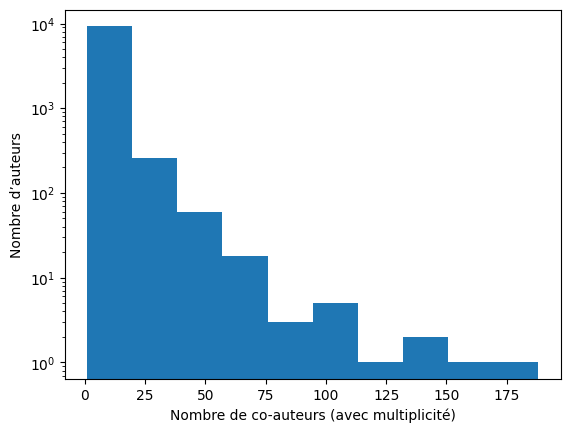

In [152]:
weighted = True  # True pour compter un même co-auteur autant de fois qu’il y a de papiers en commun ; cela ne change pas beaucoup l’analyse
degrees = [degree for _, degree in author_graph.degree(weight=("weight" if weighted else None))]
plt.hist(degrees)
plt.xlabel("Nombre de co-auteurs " + ("(avec multiplicité)" if weighted else "(sans multiplicité)"))
plt.ylabel("Nombre d’auteurs")
plt.gca().set_yscale("log")  # log scale
print("Co-auteurs par auteur :", sorted(degrees, reverse=True))

## Analyse par composantes connexes

La méthode la plus simple/rapide est de définir une communauté comme une composante connexe du graphe.

Autrement dit, deux personnes font partie de la même communauté si il existe une chaîne de co-auteurs entre elles.

In [153]:
# Calcul des composantes connectées, triées par taille décroissante
cc = sorted(nx.connected_components(author_graph), key=len, reverse=True)

# On compte le nombre de communautés, et leur taille
from collections import Counter

size_counts = Counter(len(c) for c in cc)

print(len(cc), "composantes connectées")
for size in sorted(size_counts.keys(), reverse=True):
    print(f"{size_counts[size]} composante(s) de taille {size}")


634 composantes connectées
1 composante(s) de taille 7437
1 composante(s) de taille 18
2 composante(s) de taille 16
2 composante(s) de taille 14
5 composante(s) de taille 12
3 composante(s) de taille 11
3 composante(s) de taille 10
6 composante(s) de taille 9
8 composante(s) de taille 8
17 composante(s) de taille 7
25 composante(s) de taille 6
32 composante(s) de taille 5
90 composante(s) de taille 4
161 composante(s) de taille 3
278 composante(s) de taille 2


On a une composante gigantesque qui contient 95% des auteurs, et de nombreuses autres composantes minuscules (moins de 20 personnes).

Ce résultat pouvait être attendu : les chercheurs d’un domaine forment un ensemble assez fortement connecté, donc le graphe "percole". (Cf. https://en.wikipedia.org/wiki/Erd%C5%91s_number pour le cas connu des chercheurs en mathématiques.)

L’analyse est donc peu informative : elle ne nous dit pas si il existe des sous-communautés distinctes au sein de cette composante principale. En revanche, on peut raisonnablement supposer que les petites composantes sont peu importantes, et représentent des personnes ou groupes de recherches peu reliés au reste des chercheurs du domaine. Comme ces sous-composantes seraient de toute façon identifiées comme des clusters indépendants dans un clustering raisonnable, je décide de ne garder que la composante connexe principale dans la suite de l’analyse.

In [154]:
main_author_graph = author_graph.subgraph(cc[0]).copy()
nx.write_edgelist(main_author_graph, DATA_DIR / "main_coauthor_edges.txt", data=["weight"])

## Analyse par MCL (Markov clustering)

Pour aller plus loin, il faut recourir à un algorithme de clustering plus sophistiqué.

Une brève recherche internet (10-15 min) permet d’identifier l’algorithme MCL comme un bon candidat (van Dongen, Stijn, Graph clustering via a discrete uncoupling process, Siam Journal on Matrix Analysis and Applications 30-1, p121-141, 2008, https://doi.org/10.1137/040608635). J’ai initialement essayé d’utiliser [une implémentation Python](https://github.com/GuyAllard/markov_clustering) mais celle-ci semble buggée (mauvaise compatibilité avec les nouvelles versions de scipy), j’ai donc directement utilisé l’[utilitaire source](https://github.com/micans/mcl).

Cet algorithme prend un paramètre en entrée ("inflation"), qui règle la granularité des clusters obtenus (inflation plus basse = moins de clusters). La documentation [recommande de procéder par essais-erreurs pour trouver la valeur appropriée, en prenant en compte le contexte](https://micans.org/mcl/man/mclfaq.html#faq7.2).

J’ai choisi arbitrairement que le nombre de "communautés" dans l’ensemble considéré devait être entre 10 et 100, ne serait-ce que pour faciliter la visualisation ultérieure du graphe. Une valeur d’inflation de 1.2 (trouvée par tâtonnements) satisfait ce choix (58 clusters identifiés). 

In [155]:
! mcl data/main_coauthor_edges.txt --abc -o data/mcl_clusters.txt -I 1.2

[mcl] new tab created
[mcl] pid 46366
 ite -------------------  chaos  time hom(avg,lo,hi) m-ie m-ex i-ex fmv
  1  ...................  91.77  0.03 0.95/0.02/1.66 6.97 6.97 6.97   0
  2  ................... 116.26  0.37 0.62/0.10/1.28 24.05 4.19 29.19  71
  3  ................... 136.22  2.34 0.47/0.09/1.15 22.33 1.41 41.27  99
  4  ................... 138.69  3.78 0.39/0.06/1.05 19.21 1.22 50.49  99
  5  ................... 159.22  5.13 0.35/0.06/0.98 17.13 1.09 54.80 100
  6  ................... 166.50  5.44 0.35/0.04/0.98 15.91 0.96 52.56 100
  7  ................... 141.15  4.59 0.37/0.03/0.99 15.29 0.84 44.28 100
  8  ................... 111.01  3.21 0.43/0.06/1.06 14.52 0.74 32.70 100
  9  ...................  78.99  1.74 0.49/0.09/0.99 13.19 0.66 21.56  99
 10  ...................  51.88  0.81 0.57/0.09/1.06 11.22 0.62 13.32  98
 11  ...................  37.66  0.37 0.63/0.11/1.00 8.88 0.61 8.09  91
 12  ...................  23.47  0.17 0.71/0.17/1.18 6.22 0.62 5.02  74
 13  ...

On peut ensuite vérifier la distribution de taille des différentes communautés ainsi trouvées.

Tailles de communautés : [2947, 574, 365, 330, 284, 282, 213, 186, 153, 148, 130, 118, 106, 101, 93, 92, 86, 72, 67, 67, 64, 53, 52, 49, 49, 44, 41, 41, 39, 39, 38, 36, 33, 32, 28, 26, 26, 25, 24, 23, 21, 21, 19, 19, 18, 17, 16, 16, 16, 15, 13, 12, 12, 11, 10, 9, 9, 7]


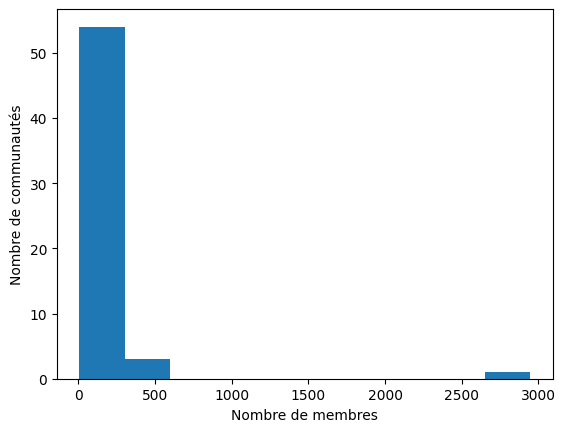

In [156]:
def read_mcl_labels(file: pathlib.Path = DATA_DIR / "mcl_clusters.txt") -> list[set]:
    with open(file, "rt") as fifi:
        result = []
        for cur_line in fifi:
            if cur_line.strip():  # skip the last, empty line
                cur_set = set(int(s) for s in cur_line.split())
                result.append(cur_set)
    return sorted(result, key=len, reverse=True)

cluster_sets = read_mcl_labels()

print("Tailles de communautés :", [len(cluster) for cluster in cluster_sets])

plt.hist([len(cluster) for cluster in cluster_sets])
plt.xlabel("Nombre de membres")
plt.ylabel("Nombre de communautés")
plt.show()

Une grosse communauté regroupe une grande partie des membres, et il y a des très petites communautés en queue de distribution. Cependant, la plus grande communauté regroupe moins de la moitié des membres, et il y a une douzaine de communautés assez grandes (plus de 100 personnes). Le résultat semble donc plus informatif que dans le cas des composantes connexes.

On visualiser les communautés ainsi définies sur le graphe. Dans la mesure où le graphe a plus de 5000 points, il est préférable d’utiliser un positionnement customisé pour séparer les communautés (en plus d’une couleur spécifique).

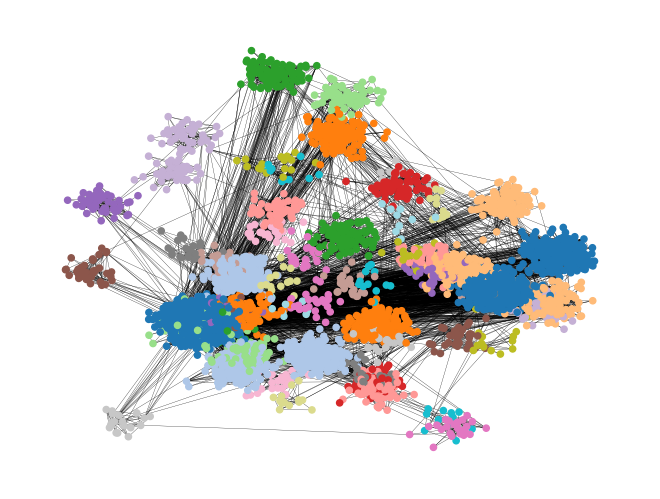

In [157]:
# Définir pour chaque nœud une valeur entre 0 et 1
# (la même valeur pour les nœuds d’un même cluster)
import matplotlib as mpl
import numpy as np

color_dict = {}
for i, cluster in enumerate(cluster_sets):
    for id_node in cluster:
        color_dict[id_node] = i/(len(cluster_sets)-1)

color_array = [color_dict[node] for node in main_author_graph.nodes]
color_map = mpl.colormaps["tab20"]

# Montrer le graphe
SEED = 123 # mettre à None pour faire varier les résultats
RNG = np.random.default_rng(seed=SEED)
def _rand2dvector() -> np.ndarray:
    return RNG.normal(size=(2,))

# Fonction de positionnement custom : chaque nœud est placé aléatoirement mais proche
# des autres nœuds du même cluster ; le paramètre var détermine la variabilité
# vis-à-vis du centre du cluster (var petit = positions très groupées).
def cluster_positioning(cset: list[set], var: float = 0.1) -> dict[int, np.ndarray]:
    """The lower var, the better clusters are grouped together."""

    positions = dict()
    for cluster in cset:
        cluster_center = _rand2dvector()
        for node in cluster:
            positions[node] = cluster_center + var * _rand2dvector()
    return positions

GRAPH_POSITIONS = cluster_positioning(cluster_sets)


nx.draw(
    main_author_graph,
    pos=GRAPH_POSITIONS,
    node_color=color_array,
    cmap=color_map,
    node_size=20,
    width=0.2,
    )


# Auteurs remarquables

J’ai utilisé un critère simple : les auteurs remarquables sont identifiés comme les 10 auteurs ayant le plus de co-auteurs, avec pondération (un co-auteur sur 5 papiers compte comme 5 co-auteurs sur 1 papier).

Ce critère brut (nombre de co-auteurs) est évidemment très discutable, notamment parce qu’il ne prend pas en compte l’"influence" des co-auteurs : un chercheur senior qui encadre peu de chercheurs juniors (doctorants / post-doctorants) mais publie beaucoup avec d’autres chercheurs senior sera moins bien classé par ce critère qu’un chercheur senior avec de nombreux doctorants et post-doctorants. On pourrait imaginer utiliser l’algorithme [PageRank](https://en.wikipedia.org/wiki/PageRank) à la place (mais j’ai manqué de temps pour cela).


In [158]:
# Retrieve "coauthorship scores" and sort
author_weights_df = pd.DataFrame.from_records([
        {"id": id, "coauth_score": cs}
        for id, cs in main_author_graph.degree(weight="weight")
    ]
)
author_weights_df.sort_values(by="coauth_score", ascending=False, inplace=True)

full_author_weights_df = author_weights_df.merge(authors_df, on="id")
print("Auteurs remarquables (par nombre de co-auteurs) :")
display(full_author_weights_df[:10])

Auteurs remarquables (par nombre de co-auteurs) :


,id,coauth_score,name
0,1472,188,Bernhard Sch?lkopf
1,178,158,Yoshua Bengio
2,330,150,Michael I. Jordan
3,3001,146,Lawrence Carin
4,1282,129,Klaus-Robert M?ller
5,1410,113,Alex J. Smola
6,1853,105,Andrew Y. Ng
7,1020,104,Zoubin Ghahramani
8,3161,101,Le Song
9,121,98,Geoffrey E. Hinton


On peut ensuite mettre en évidence ces auteurs sur le graphe (ici, en rouge).

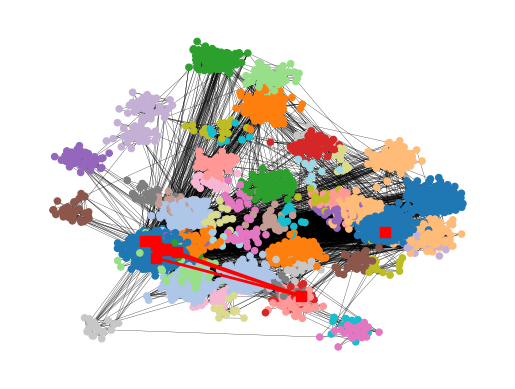

In [159]:
remarkable_ids = set(full_author_weights_df[:10]["id"])

remarkable_author_graph = main_author_graph.subgraph(remarkable_ids)

# Plot sur des axes séparés : pour que les auteurs remarquables soient par-dessus
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.sharey(ax1)

nx.draw(
    main_author_graph,
    ax=ax1,
    pos=GRAPH_POSITIONS,
    node_color=color_array,
    cmap=color_map,
    node_size=20,
    width=0.2,
    )
plt.gcf().canvas.draw()
plt.gcf().canvas.flush_events()
nx.draw(
    remarkable_author_graph,
    ax=ax2,
    pos=GRAPH_POSITIONS,
    node_color = "red",
    node_size = 50,
    edge_color="red",
    node_shape="s",
    width=2,
)